In [1]:
student_Name='Bobb Shields'
student_ID='wde677'
dataset_URL='https://www.kaggle.com/datasets/sheacon/tn-mvr-2018-2022'

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split


Noting changes made 4/4 due to mistakes in data prep.  "HINO" is a commercial truck manufacturer, so removed from imports category, pushing it into other.  And the sports mask was showing the imports group - corrected that typo.  

4/29 Update - Dropped commercial trucks and winnebagos that dont' fit the cars + trucks schema.  These were supposed to have been dropped in filtering down on type variable. Removed the max price on luxury vehicles.  Dropped non-luxury maximum to 250k.  Changes made in Data Prep notebook, iterated the filename to v3. 

Filters have been applied to reduce this to automobiles only, less than 500k miles, less than 100 years old, less than $10mil, 

Things need to be checked.  MERC and MERZ fixed in download but look for further duplicates.  Model A's shown in these transactions so maybe an age limit is appropriate.  Not sure that a Nissan Altima will appreciate the same way as a Model A lol 

Check for duplicate records per VIN and look at historical trends <- Stretch goal, struggling 4/17

Treat new car price averages as maximum, unless luxury/discontinued brings a postitive curve due to antique-ness <-Still brewing


In [2]:
import time
startTime = time.time()
mostRecentTime = startTime

nowish = (time.time() - startTime)
print('Start time: ' + str(nowish))
print("(in seconds)")

Start time: 0.0
(in seconds)


In [3]:
#have filtered down the project dataset 
tn_auto_reg_f = pd.read_csv('tn_auto_reg_filtered_CT3.csv',low_memory=False)
tn_auto_reg_f.describe().round()

,price,odometer_type,mileage,model_year,age,make_cat_popular,make_cat_imports,make_cat_sports,make_cat_luxury,make_cat_discontinued,make_cat_other,type_AUTO,type_TRUCK,new_used_N,new_used_U
count,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0
mean,22557.0,0.0,69581.0,2015.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
std,22198.0,1.0,66420.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,300.0,0.0,1.0,1915.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,7500.0,0.0,8525.0,2012.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
50%,18500.0,0.0,54849.0,2016.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
75%,32328.0,0.0,113099.0,2019.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
max,9534253.0,9.0,750000.0,2023.0,105.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [4]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Data loaded: ' + str(round(nowish,0)) )
print("Last section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Data loaded: 8.0
Last section took: 8.0
(in seconds)


In [5]:
tn_auto_reg_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231111 entries, 0 to 1231110
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   vin                    1231111 non-null  object 
 1   price                  1231111 non-null  float64
 2   odometer_type          1231111 non-null  int64  
 3   mileage                1231111 non-null  int64  
 4   county                 1231111 non-null  object 
 5   zip                    1231111 non-null  object 
 6   model_year             1231111 non-null  int64  
 7   make                   1231111 non-null  object 
 8   model                  1231111 non-null  object 
 9   vehicle_type           1231111 non-null  object 
 10  new_used               1231111 non-null  object 
 11  title_issue_date       1231111 non-null  object 
 12  purchase_date          1231111 non-null  object 
 13  age                    1231111 non-null  int64  
 14  make_cat_popular  

In [6]:
# Define mask variables
mask_popular = tn_auto_reg_f['make_cat_popular'] == 1
mask_sports = tn_auto_reg_f['make_cat_sports'] == 1
mask_imports = tn_auto_reg_f['make_cat_imports'] == 1
mask_luxury = tn_auto_reg_f['make_cat_luxury'] == 1
mask_discontinued = tn_auto_reg_f['make_cat_discontinued'] == 1
mask_other = tn_auto_reg_f['make_cat_other'] == 1
mask_auto = tn_auto_reg_f['type_AUTO'] == 1
mask_truck = tn_auto_reg_f['type_TRUCK'] == 1
mask_new = tn_auto_reg_f['new_used_N'] == 1
mask_used = tn_auto_reg_f['new_used_U'] == 1

In [7]:
tn_auto_reg_f['price_log'] = np.log1p(tn_auto_reg_f['price'])
tn_auto_reg_f['mileage_log'] = np.log1p(tn_auto_reg_f['mileage'])


Showing transformations on right side that will be prefered in ML algorithm


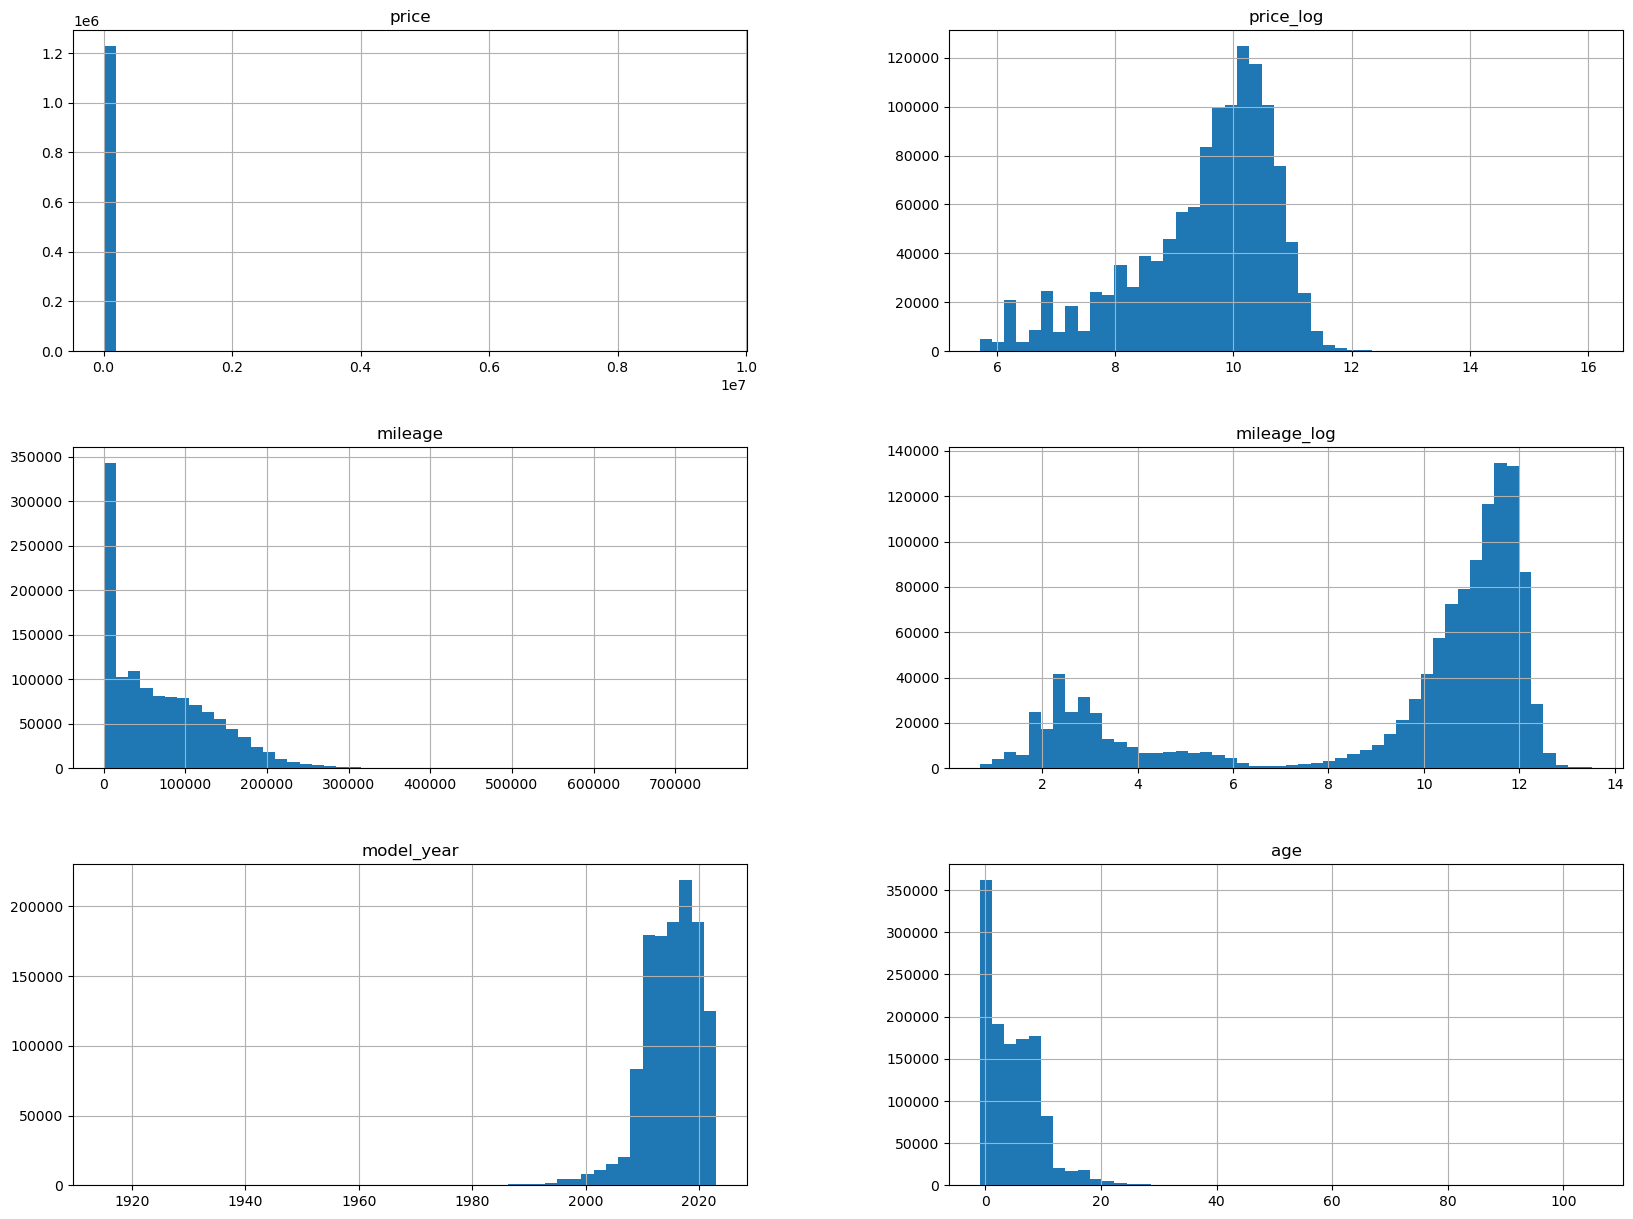

In [8]:
print("Showing transformations on right side that will be prefered in ML algorithm")
tn_auto_reg_f[["price","price_log","mileage","mileage_log","model_year","age"]].hist(bins=50, figsize=(20,15))
plt.show()

In [9]:
# determine an average price for each make/model for both new and used vehicles
avg_price = tn_auto_reg_f.groupby(['make', 'model', 'new_used_N'])['price'].mean().reset_index()
avg_price = avg_price.pivot_table(index=['make', 'model'], columns='new_used_N', values='price', aggfunc='first').reset_index()
avg_price.columns.name = None
avg_price = avg_price[['make', 'model', 1, 0]]

# filter to only rows with non-null values in both 'new' and 'used' columns
avg_price_filtered = avg_price[avg_price[[1, 0]].notnull().all(axis=1)]

# change column names 
avg_price_filtered = avg_price_filtered.rename(columns={'1': 'new_avg', '0': 'used_avg'})

print("Average prices shown below: 1 is New, 0 is Used")
print(avg_price_filtered.sample(20).round(0))

print("Seeing some models go up on average.")

Average prices shown below: 1 is New, 0 is Used
      make model         1         0
3678  HYUN   5NT   36558.0   44374.0
6423  SUBA   4S4   41088.0   21795.0
5594  NISS   3N1   21744.0   12127.0
107   AUDI   4MG   96025.0   83849.0
6973  TOYT   VNZ   41022.0   17744.0
157   AUDI    A7   75670.0   28219.0
724   CADI   6NK   63964.0   42189.0
5156  MERC   E30   55368.0   35860.0
1583  CHRY   200   22894.0    8179.0
258   AUDI   SQ8  104490.0  107079.0
5249  MERC   M1C   37983.0   20831.0
5215  MERC   GLB   49050.0   41663.0
338    BMW   330   47610.0   25624.0
2117  FORD   250   47588.0   23983.0
637   BUIC   LAX   40049.0   12548.0
1738  DODG   2C3   38445.0   27990.0
5043  MERC   3AM  212170.0   71200.0
6543  SUBA   WRX   32581.0   22748.0
6753  TOYT   GR8   32863.0   39288.0
4918  MAZD   HBK   28347.0   26990.0
Seeing some models go up on average.


             price_log  mileage_log   age  new_used_N  type_TRUCK
price_log         1.00        -0.55 -0.70        0.42        0.18
mileage_log      -0.55         1.00  0.63       -0.86       -0.04
age              -0.70         0.63  1.00       -0.49       -0.01
new_used_N        0.42        -0.86 -0.49        1.00        0.05
type_TRUCK        0.18        -0.04 -0.01        0.05        1.00


<AxesSubplot: title={'center': 'Population - New/Used Cars/Trucks'}>

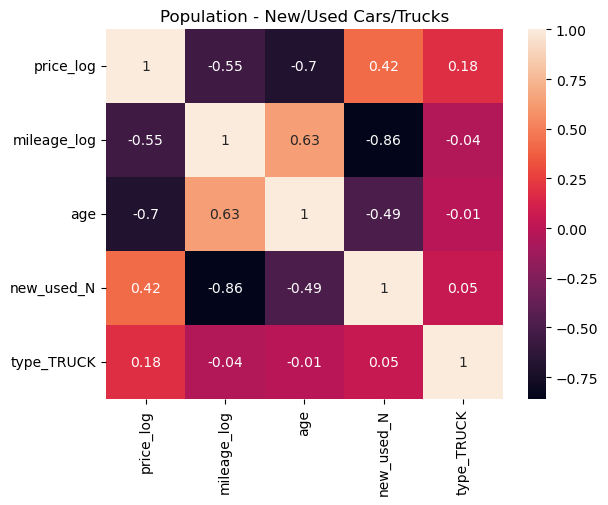

In [10]:
#overall corr analysis
tn_auto_reg_f_hm = tn_auto_reg_f[["price_log","mileage_log","age",'new_used_N',"type_TRUCK"]].corr().round(2)
print(tn_auto_reg_f_hm)
plt.title("Population - New/Used Cars/Trucks")
sns.heatmap(tn_auto_reg_f_hm, annot=True)

Adding new features and testing around.  Should have done this the first time around :/


<AxesSubplot: title={'center': 'Population - New/Used Cars/Trucks'}>

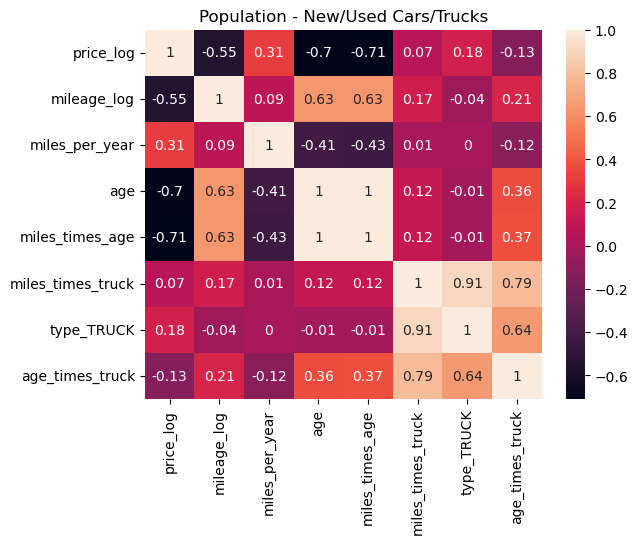

In [11]:
print("Adding new features and testing around.  Should have done this the first time around :/")

tn_auto_reg_f["miles_per_year"] = tn_auto_reg_f["mileage_log"] / tn_auto_reg_f["age"]
tn_auto_reg_f["miles_times_truck"] = tn_auto_reg_f["mileage_log"] * tn_auto_reg_f["type_TRUCK"]
tn_auto_reg_f["miles_times_age"] = tn_auto_reg_f["mileage_log"] * tn_auto_reg_f["age"]
tn_auto_reg_f["age_times_truck"] = tn_auto_reg_f["age"] * tn_auto_reg_f["type_TRUCK"]

tn_auto_reg_f_hm2 = tn_auto_reg_f[["price_log", "mileage_log","miles_per_year","age", 'miles_times_age',
                                  "miles_times_truck","type_TRUCK","age_times_truck"]].corr().round(2)
#print(tn_auto_reg_f_hm2)
plt.title("Population - New/Used Cars/Trucks")
sns.heatmap(tn_auto_reg_f_hm2, annot=True)


Liking miles_per_year as an indicator of wear and tear.  Miles_times_truck comes in at .007 which pales in comparison of truck at .18 and mileage_log at -.55.

Interesting that miles_times_age has a -.71 which beats mileage_log at -.55 and age at -.07.  Might use this feature and delete the other two from the new transformer. 

In [12]:
#trim down models because there is trash in it
print(tn_auto_reg_f['model'].value_counts().tail(10) )

model_counts = tn_auto_reg_f['model'].value_counts()
selected_models = model_counts[model_counts > 200].index
tn_auto_reg_f = tn_auto_reg_f[tn_auto_reg_f['model'].isin(selected_models)]

print("Finished trimming (models with fewer than 200 transactions were deleted.)\nCounts of models and stats on number of records")
print(tn_auto_reg_f['model'].value_counts().describe() )

4HP    1
R1Z    1
SJN    1
E4H    1
R70    1
QTO    1
BV4    1
O6R    1
F5S    1
F40    1
Name: model, dtype: int64
Finished trimming (models with fewer than 200 transactions were deleted.)
Counts of models and stats on number of records
count      505.000000
mean      2287.871287
std       4646.336791
min        201.000000
25%        341.000000
50%        646.000000
75%       1825.000000
max      47718.000000
Name: model, dtype: float64


In [13]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Setup completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Setup completed (total time): 18.0
This section took: 10.0
(in seconds)


Below is the code for the final stagegate of this term project. 

In [14]:
print("Dropping all non-feature columns\n")
dropped = tn_auto_reg_f
dropped = dropped.drop("vin", axis=1)
dropped = dropped.drop("odometer_type", axis=1)
dropped = dropped.drop("county", axis=1)
dropped = dropped.drop("zip", axis=1)
dropped = dropped.drop("model_year", axis=1)
dropped = dropped.drop("vehicle_type", axis=1)
dropped = dropped.drop("new_used", axis=1)
dropped = dropped.drop("title_issue_date", axis=1)
dropped = dropped.drop("purchase_date", axis=1)
dropped = dropped.drop("mileage", axis=1)
dropped = dropped.drop("price", axis=1)

dropped = dropped.drop("make_cat_popular", axis=1)
dropped = dropped.drop("make_cat_imports", axis=1)
dropped = dropped.drop("make_cat_sports", axis=1)
dropped = dropped.drop("make_cat_discontinued", axis=1)
dropped = dropped.drop("make_cat_other", axis=1)
dropped = dropped.drop("type_AUTO", axis=1)
dropped = dropped.drop("new_used_U", axis=1)

dropped = dropped.drop("miles_times_truck", axis=1)
dropped = dropped.drop("age_times_truck", axis=1)

dropped = dropped.drop("miles_per_year", axis=1) #keeping this as a measure of excessive wear and tear
dropped = dropped.drop("miles_times_age", axis=1) #decided to delete this in the end.  
#already have miles and age included as strong indicators


#dropped = dropped.drop("make", axis=1)  #One hot encoded!
#dropped = dropped.drop("model", axis=1)  #One hot encoded!

#Hot encode for: "FORD-F150"
#Check for intereaction between mileage and type of vehicle
# age * mileage 
# ageXmileage * vehicle type (or make or model) 

dropped.info()

Dropping all non-feature columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1155375 entries, 0 to 1231110
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   make             1155375 non-null  object 
 1   model            1155375 non-null  object 
 2   age              1155375 non-null  int64  
 3   make_cat_luxury  1155375 non-null  int64  
 4   type_TRUCK       1155375 non-null  int64  
 5   new_used_N       1155375 non-null  int64  
 6   price_log        1155375 non-null  float64
 7   mileage_log      1155375 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 79.3+ MB


<AxesSubplot: title={'center': 'Population - New/Used Cars/Trucks'}>

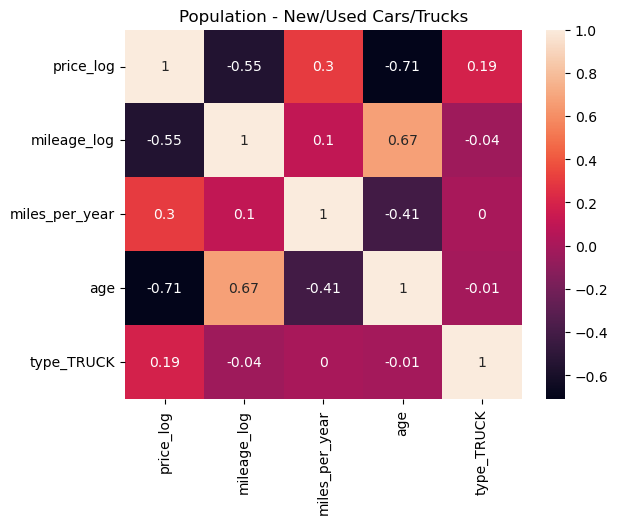

In [15]:

tn_auto_reg_f_hm2 = tn_auto_reg_f[["price_log", "mileage_log","miles_per_year","age", "type_TRUCK"]].corr().round(2)
#print(tn_auto_reg_f_hm2)
plt.title("Population - New/Used Cars/Trucks")
sns.heatmap(tn_auto_reg_f_hm2, annot=True)


In [16]:
#Shuffle the final df
dropped_shuffled = dropped.sample(frac=1)

#Split into train and set 
train_set, test_set = train_test_split(dropped_shuffled, test_size=0.2, random_state=42)


#tn_auto_reg_f_cat_make = tn_auto_reg_f[['make']]
#tn_auto_reg_f_cat_model = tn_auto_reg_f[['model']]

In [17]:
def price_cat_proportions(data):
    #print ("Data_price_log.value_counts() = \n" + str(data["price_log"].value_counts() ) +" and len = " + str( (len(data) + 1e-10 )))
    return data["price_log"].value_counts() / (len(data) + 1e-10)


compare_props = pd.DataFrame({
    "Overall": price_cat_proportions(tn_auto_reg_f),
    #"Stratified": price_cat_proportions(strat_test_set_disc),
    "Random": price_cat_proportions(test_set),
}).sort_index()#.fillna(0) #<- Debugging Flag - Not sure about .fillna(0) here.  Should figure out why NaNs popped up. 
compare_props["Rand. %error"] = ( 100 * compare_props["Random"] ) / (compare_props["Overall"] - 100 )    #<- are these supposed
#compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100 #<- to be different? Was 1

#Look for divide by zero errors here => NaN 

## the stratified better reflects the original distribution?
compare_props.sample(15).round(-1)

,Overall,Random,Rand. %error
10.338867,0.0,NaN,NaN
11.334773,0.0,0.0,-0.0
10.264848,0.0,NaN,NaN
9.769088,0.0,NaN,NaN
10.181941,0.0,NaN,NaN
11.065951,0.0,0.0,-0.0
10.299172,0.0,0.0,-0.0
9.975696,0.0,NaN,NaN
9.486137,0.0,0.0,-0.0
8.820789,0.0,NaN,NaN


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

In [19]:
from sklearn.preprocessing import OrdinalEncoder

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder()),
])

In [20]:
# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
#rooms_ix, bedrooms_ix, population_ix, household_ix = [
#    list(housing.columns).index(col)
#    for col in ("total_rooms", "total_bedrooms", "population", "households")]
#bedrooms_ix

#def add_extra_features(X, add_bedrooms_per_room=True):
#    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
#    population_per_household = X[:, population_ix] / X[:, household_ix]
#    if add_bedrooms_per_room:
#        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
#        return np.c_[X, rooms_per_household, population_per_household,
#                     bedrooms_per_room]
#    else:
#        return np.c_[X, rooms_per_household, population_per_household]

In [21]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        #('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

In [22]:
#Copy the target into the labels set
registrations_labels = train_set['price_log'].copy()

#Copy the dropped data into the registrations df 
registrations = train_set.drop('price_log',axis=1).copy()

print(registrations.info() )
print("\n")
print(registrations_labels.info() )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 924300 entries, 109980 to 1130270
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   make             924300 non-null  object 
 1   model            924300 non-null  object 
 2   age              924300 non-null  int64  
 3   make_cat_luxury  924300 non-null  int64  
 4   type_TRUCK       924300 non-null  int64  
 5   new_used_N       924300 non-null  int64  
 6   mileage_log      924300 non-null  float64
dtypes: float64(1), int64(4), object(2)
memory usage: 56.4+ MB
None


<class 'pandas.core.series.Series'>
Int64Index: 924300 entries, 109980 to 1130270
Series name: price_log
Non-Null Count   Dtype  
--------------   -----  
924300 non-null  float64
dtypes: float64(1)
memory usage: 14.1 MB
None


In [23]:
registrations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 924300 entries, 109980 to 1130270
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   make             924300 non-null  object 
 1   model            924300 non-null  object 
 2   age              924300 non-null  int64  
 3   make_cat_luxury  924300 non-null  int64  
 4   type_TRUCK       924300 non-null  int64  
 5   new_used_N       924300 non-null  int64  
 6   mileage_log      924300 non-null  float64
dtypes: float64(1), int64(4), object(2)
memory usage: 56.4+ MB


In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = ["mileage_log","age"] 
cat_attribs = ["new_used_N","make_cat_luxury","type_TRUCK"]
hot_attribs = ["make", "model"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
        ("hot", OneHotEncoder(), hot_attribs), 
    ])

registrations_prepared = full_pipeline.fit_transform(registrations)

C:\Users\bobbs\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [25]:
registrations_prepared

<924300x553 sparse matrix of type '<class 'numpy.float64'>'
	with 4086223 stored elements in Compressed Sparse Row format>

In [26]:
registrations_prepared.shape

(924300, 553)

In [27]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Pipline created (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Pipline created (total time): 30.0
This section took: 12.0
(in seconds)


In [28]:
#import statsmodels.api as sm
#X_const = sm.add_constant(registrations_prepared)
#OLS_model = sm.OLS(registrations_labels,X_const) 
#result = OLS_model.fit()
#result.summary()

In [29]:
from sklearn.linear_model import LinearRegression

#Maybe flip flopped _prepared and _labels here 

lin_reg = LinearRegression()
lin_reg.fit(registrations_prepared, registrations_labels)
 

LinearRegression()

In [30]:
print(registrations_prepared.shape)
print(registrations_labels.shape)

(924300, 553)
(924300,)


In [31]:
# let's try the full preprocessing pipeline on a few training instances
#some_data = registrations_prepared[:5]
#some_labels = registrations_labels[:5]

#cols = num_attribs + cat_attribs + hot_attribs

#some_data_df = pd.DataFrame(some_data, columns=cols)

#some_data_prepared = full_pipeline.transform(some_data_df)



In [32]:
#Compare prediction against the actual values
#print("Predictions:", list(np.round(lin_reg.predict(some_data_prepared),1)))
#print("Labels     :", list(some_labels))

In [33]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('First Predictions Completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

First Predictions Completed (total time): 54.0
This section took: 24.0
(in seconds)


In [34]:
from sklearn.metrics import mean_squared_error

vehicle_price_predictions = lin_reg.predict(registrations_prepared)
lin_mse = mean_squared_error(registrations_labels, vehicle_price_predictions)
lin_rmse = np.sqrt(lin_mse)

print("Root Mean Squared Error:", round(lin_rmse,-2))


Root Mean Squared Error: 0.0


In [35]:
from sklearn.metrics import mean_absolute_error

registrations_predictions = lin_reg.predict(registrations_prepared)
lin_mae = mean_absolute_error(registrations_labels, registrations_predictions)
print("Mean Absolute Error:", round(lin_mae,1))

Mean Absolute Error: 0.4


In [36]:
# from sklearn.metrics import mean_absolute_percentage_error# mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Absolute Percentage Error:")
round(mean_absolute_percentage_error(registrations_labels, registrations_predictions),1)

#This is the one to use to show how wide the error band is in real world prices

Absolute Percentage Error:


5.1

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_models(models, prepared_data, labels):
    rows = []
    for i, model in enumerate(models):
        name = f"Model {i+1}"
        predictions = model.predict(prepared_data)
        mse = mean_squared_error(labels, predictions)
        rmse = np.sqrt(mse)
        rmse_error_dollars = 2 * np.exp(rmse)
        mae = mean_absolute_error(labels, predictions)
        r2 = r2_score(labels, predictions)
        row = {"Model": name, "RMSE": rmse, "$Error":rmse_error_dollars,"MAE": mae, "R2 Score": r2}
        rows.append(row)
    return pd.DataFrame(rows)

In [43]:
#Evaluate differences in the models 
models = [lin_reg]
df = evaluate_models(models, registrations_prepared, registrations_labels)
df['Model'] = ['lin']
print("Revised Algorithm Scores")
print(df)

Revised Algorithm Scores
  Model      RMSE   $Error       MAE  R2 Score
0   lin  0.644855  3.81142  0.441857  0.689988


From first algorithm:

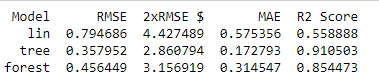

RMSE, the 2x Error band in dollars, and the MAE go down significally in the new model.  R2 is also up dramatically from .55 to .68.  This model is signicantly improved over the previous attempt. 

In [42]:
Aaaand I'm choosing to end my extra credit here.  The below is so slow that it 
hasn't fully computed for me and its likely full of bugs 
But linear's performance improved, right!?  That's worth some extra credit, eh?

SyntaxError: invalid syntax (2882706283.py, line 1)

In [ ]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Errors computed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

#Slow below here#

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(registrations_prepared, registrations_labels)

In [ ]:
registrations_predictions = tree_reg.predict(registrations_prepared)
tree_mse = mean_squared_error(registrations_labels, registrations_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

In [ ]:
mean_absolute_percentage_error(registrations_labels, registrations_predictions)

In [ ]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Tree fit completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(registrations_prepared, registrations_labels)

In [ ]:
registrations_predictions = forest_reg.predict(registrations_prepared)
forest_mse = mean_squared_error(registrations_labels, registrations_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

In [ ]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Forest fit completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

In [ ]:
#Copy the target into the labels set
test_Y = test_set['price_log'].copy()

#Copy the dropped data into the registrations df 
test_X = test_set.drop('price_log',axis=1).copy()

In [ ]:
#choosing tree_reg as the best fit with an rmse of .36 since lower than 
#forest_reg at .46, and assuming linear_reg is errored at 0
tree_predictions = tree_reg.predict(test_X)

In [ ]:
from sklearn.metrics import r2_score
r2_score(test_Y, tree_predictions)

In [ ]:
#choosing tree_reg as the best fit with an rmse of .36 since lower than 
#forest_reg at .46, and assuming linear_reg is errored at 0
forest_predictions = forest_reg.predict(test_X)

In [ ]:
r2_score(test_Y, forest_predictions)

In [ ]:
#choosing tree_reg as the best fit with an rmse of .36 since lower than 
#forest_reg at .46, and assuming linear_reg is errored at 0
lin_predictions = lin_reg.predict(test_X)

In [ ]:
r2_score(test_Y, lin_predictions)

In [ ]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Model prediction checking (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")
print("(_______ End of the first ML Algorithm Section _______)")

mostRecentTime = time.time()

In [ ]:
# Get predictions for linear regression model
lin_reg_predictions = lin_reg.predict(registrations_prepared)

# Get predictions for decision tree regression model
tree_reg_predictions = tree_reg.predict(registrations_prepared)

# Get predictions for random forest regression model
forest_reg_predictions = forest_reg.predict(registrations_prepared)

# Create a subplot with 1 row and 3 columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot actual vs predicted values for linear regression model
axes[0].scatter(registrations_labels, lin_reg_predictions)
axes[0].plot(registrations_labels, registrations_labels, color='red')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title('Linear Regression')

# Plot actual vs predicted values for decision tree regression model
axes[1].scatter(registrations_labels, tree_reg_predictions)
axes[1].plot(registrations_labels, registrations_labels, color='red')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title('Decision Tree Regression')

# Plot actual vs predicted values for random forest regression model
axes[2].scatter(registrations_labels, forest_reg_predictions)
axes[2].plot(registrations_labels, registrations_labels, color='red')
axes[2].set_xlabel('Actual')
axes[2].set_ylabel('Predicted')
axes[2].set_title('Random Forest Regression')

plt.tight_layout()
plt.show()

In [ ]:
#Evaluate differences in the models 
models = [lin_reg, tree_reg, forest_reg]
df = evaluate_models(models, registrations_prepared, registrations_labels)
df['Model'] = ['lin', 'tree', 'forest']
print(df)

_Room for analysis here_


[50 Extra-credit] Identify, train, and test a second algorithm that improves the predicting performance (it must improve the performance)